# Urban Sound Classificaiton
****

In [13]:
!

## 1.1 Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from scipy.io import wavfile as wav
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [2]:
meta_data = pd.read_csv("metadata/UrbanSound8K.csv")  

np.shape(meta_data) # (8732, 8)
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
print((meta_data.classID.value_counts().sort_index()))

0    1000
1     429
2    1000
3    1000
4    1000
5    1000
6     374
7    1000
8     929
9    1000
Name: classID, dtype: int64


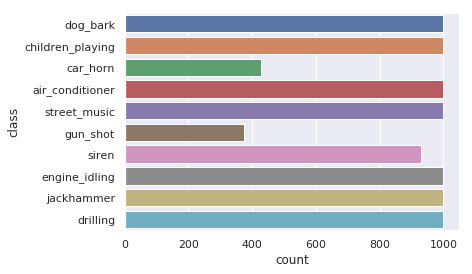

In [6]:
sns.set(style="darkgrid")
sns.countplot(y= meta_data['class'],orient='v')
plt.show()

### Waveplot for different classes

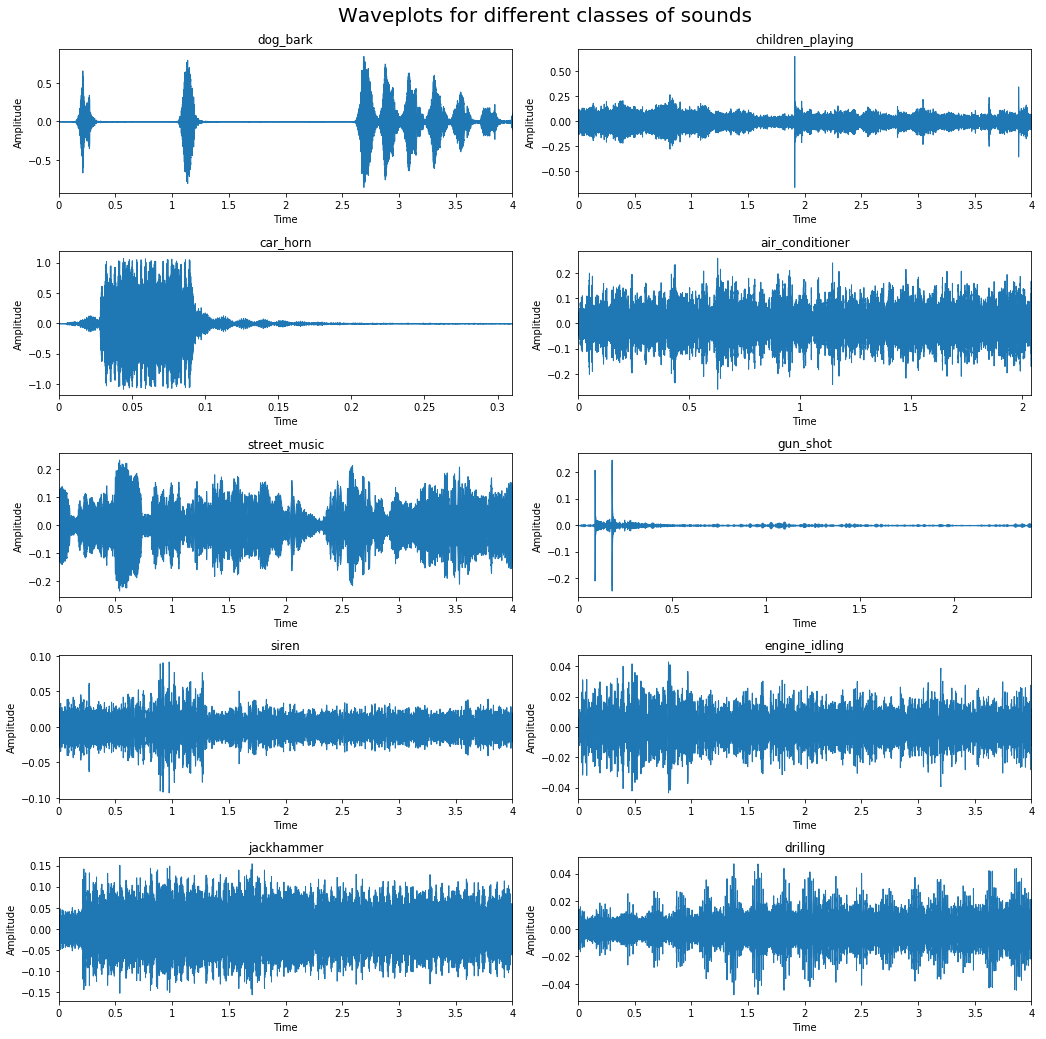

In [33]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
classes = list(meta_data['class'].unique()) 
plt.title('Waveplots for different classes of sounds\n',size=20)
plt.axis('off')
for i in range(10):
    fig.add_subplot(5,2,i+1)
    plt.title(classes[i])
    plt.ylabel('Amplitude')
    file_name = 'sample_sound/'+classes[i]+".wav"
    data,sample_rate = librosa.load(file_name)
    librosa.display.waveplot(data,sr=sample_rate)
    plt.tight_layout()

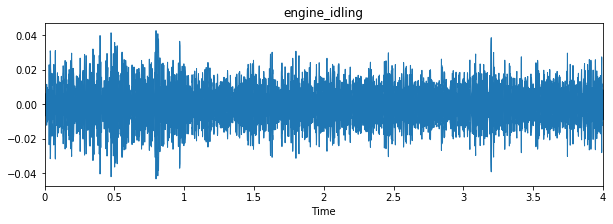

In [29]:
# Listening module for a sound class
i = 7
filename = 'sample_sound/'+classes[i]+".wav"
plt.figure(figsize=(10,3))
plt.title(classes[i])
data,sample_rate = librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

### 1.2  Extracting the metadata of the audio

In [8]:
audio_d_list = []

for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('audio/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    
    # extracting channels, sampling rate, bit rate and duration
    data = sf.SoundFile(file_name)
    duration = float(meta_data.iloc[index,3])-float(meta_data.iloc[index,2])
    audio_d_list.append([data.channels,
                         data.samplerate,
                         data.subtype[4:],
                         duration])

audio_property = pd.DataFrame(audio_d_list, 
                          columns=['num_channels','sample_rate','bit_depth','duration'])

In [9]:
audio_property.head()

,num_channels,sample_rate,bit_depth,duration
0,2,44100,16,0.317551
1,2,44100,16,4.000000
2,2,44100,16,4.000000
3,2,44100,16,4.000000
4,2,44100,16,4.000000


***
***

## 2. Inital Data Analysis

### Spectogram for different classes 

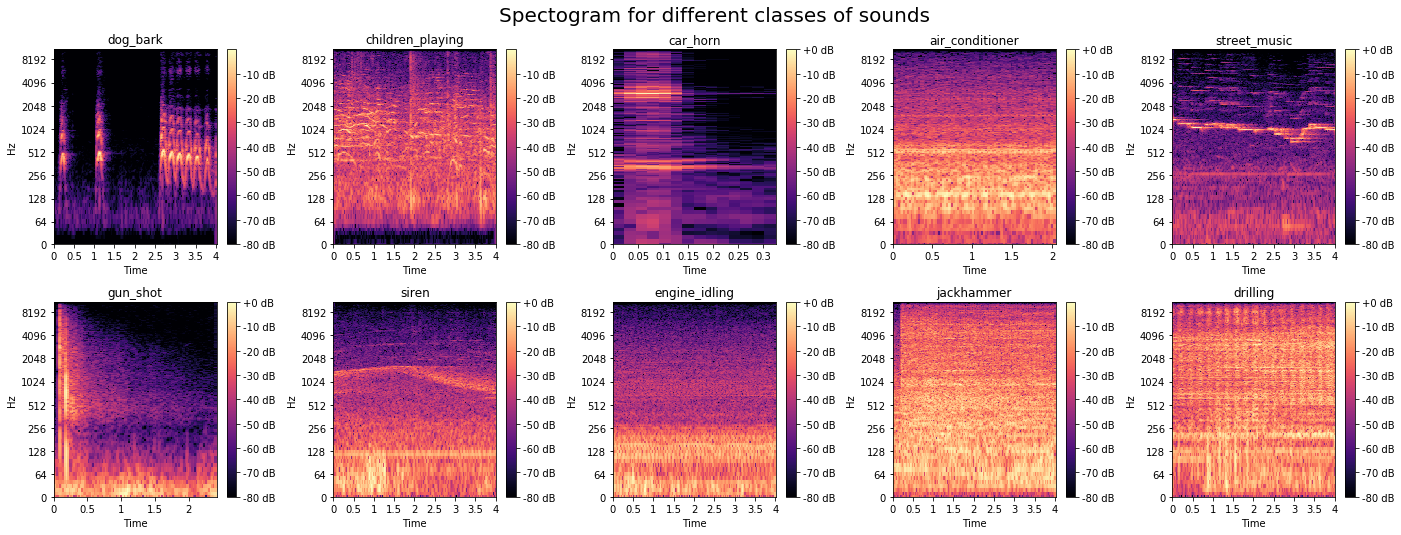

In [84]:
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
classes = list(meta_data['class'].unique()) 
plt.title('Spectogram for different classes of sounds\n',size=20)
plt.axis('off')
for i in range(10):
    fig.add_subplot(2,5,i+1)
    plt.title(classes[i])
    file_name = 'sample_sound/'+classes[i]+".wav"
    data,sample_rate = librosa.load(file_name)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, x_axis = "time",y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

### 2.1   Duration of Audio

In [10]:
print(audio_property.duration)

0       0.317551
1       4.000000
2       4.000000
3       4.000000
4       4.000000
          ...   
8727    4.000000
8728    2.142545
8729    3.505983
8730    2.532098
8731    2.532099
Name: duration, Length: 8732, dtype: float64


### 2.2 Number of Channels

Sound Channel refers to the independent audio signal which is collected or playback when the sound is recording or playback in different spatial position. Therefore, the number of channel is the amount of sound source when the sound is recording or the relevant speaker number when it is playback

In [11]:
print(audio_property.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


### 2.3 Bit Depth

Bit depth describes the resolution of the sound data that is captured and stored in an audio file. A higher audio bit depth indicates a more detailed sound recording.

In [12]:
print(audio_property.bit_depth.value_counts(normalize=True))

16       0.659414
24       0.315277
T        0.019354
U8       0.004924
DPCM     0.000916
ADPCM    0.000115
Name: bit_depth, dtype: float64


### 2.4 Sampling Frequency or Sample Rate

In audio production, a sample rate (or "sampling frequency") defines how many times per second a sound is sampled. Technically speaking, it is the frequency of samples used in a digital recording. 

In [13]:
print(audio_property.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


****
****

## 3. Data Pre-Processing

Using Librosa’s load() function:  
* Converts the sampling rate to 22.05 KHz
* Normalise the Bit-depth values of the audio
* Merge the audio channels to Mono (a single channel) 

Using Librosa MFCC function: 
* Extracting Mel Frequency Cepstral Coefficient 

Using TensorFlow backend.


In [42]:
def feature_extractor(file_name,scale=False,padding=False,max_pad=None,n=40):
    '''
    Function to extract features from the audio file
    Does the following things using Librosa library:
        - Converts the sampling rate to 22.05 KHz
        - Normalize the Bit-depth values of the audio
        - Merge the audio channels into a Mono (single) channel
    Parameters: 
    Input:
        file_name : string; 
                    Path of the file to be processed 
        scale : False; 
                True when 1D features are required calculated 
                by taking mean along the axis
        padding : False; 
                  True when 2D features are required with padding
        max_pad : None [int]; 
                  Maxium size of a padded image/array. 
                  Required when padding is set to True
        n = 40 [int]; 
            Number of MFCCs to return          
    Output:
        mfccs = array of mfccs features.
                (1D when scaling = True
                 2D when padding = True)   
    '''
    try:        
        audio, sample_rate = librosa.load(file_name, 
                                          res_type='kaiser_fast') 
        
        mfccs = librosa.feature.mfcc(y = audio, 
                                     sr = sample_rate, 
                                     n_mfcc = n) 
            
        if padding:
            pad_width = max_pad - mfccs.shape[1]
            mfccs = np.pad(mfccs, 
                           pad_width=((0, 0), (0, pad_width)), 
                           mode='constant')
            
        if scale: 
            mfccs = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

### 1-Dimensional Feature Extraction

In [16]:
feat_list = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('audio/'),
                             'fold'+str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    
    data = feature_extractor(file_name,scale=True)
    feat_list.append([data, class_label])

features_1D = pd.DataFrame(feat_list, columns=['feature','class_label'])

print('Processed ', len(features_1D), ' files')
print('Output Feature shape ',np.shape(features_1D.iloc[0,0]))

Processed  8732  files
Output Feature shape  (40,)


In [33]:
#features_1D.to_pickle("features_1D.pkl")

### 2-Dimensional Feature Extraction with and without Padding

In [32]:
feat_list = []
feat_list_padded = []
for index, row in meta_data.iterrows():
    
    file_name = os.path.join(os.path.abspath('audio/'),
                             'fold'+ str(row["fold"])+'/',
                             str(row["slice_file_name"]))
    class_label = row["class"]
    class_id = row["classID"]
    
    data = feature_extractor(file_name)
    feat_list.append([data, class_id])
    
    data = feature_extractor(file_name,padding=True,max_pad = 174)
    feat_list_padded.append([data, class_label])
    
features_wo_pad = pd.DataFrame(feat_list, columns=['feature','class_label'])
features_2D = pd.DataFrame(feat_list_padded, columns=['feature','class_label'])

print('Processed ', len(features_2D), ' files')
print('Output Feature Padded shape ',np.shape(features_2D.iloc[0,0]))

Processed  8732  files
Output Feature Padded shape  (40, 174)


In [34]:
#features_wo_pad.to_pickle("features_wo_pad.pkl")
#features_2D.to_pickle("features_2D.pkl")

In [45]:
features_1D = pd.read_pickle("features_1D.pkl")
features_2D = pd.read_pickle("features_2D.pkl")
features_wo_pad = pd.read_pickle("features_wo_pad.pkl")

### Data Visualization after MFCC

In [8]:
# choose a sample of sound from each class

sound_class_dic = meta_data.groupby(['class', 'classID']).size()
sound_sample = []

for c in range(10):
    for index, row in features_wo_pad.iterrows():
        if c == row['class_label']:
            sound_sample.append(row)
            break

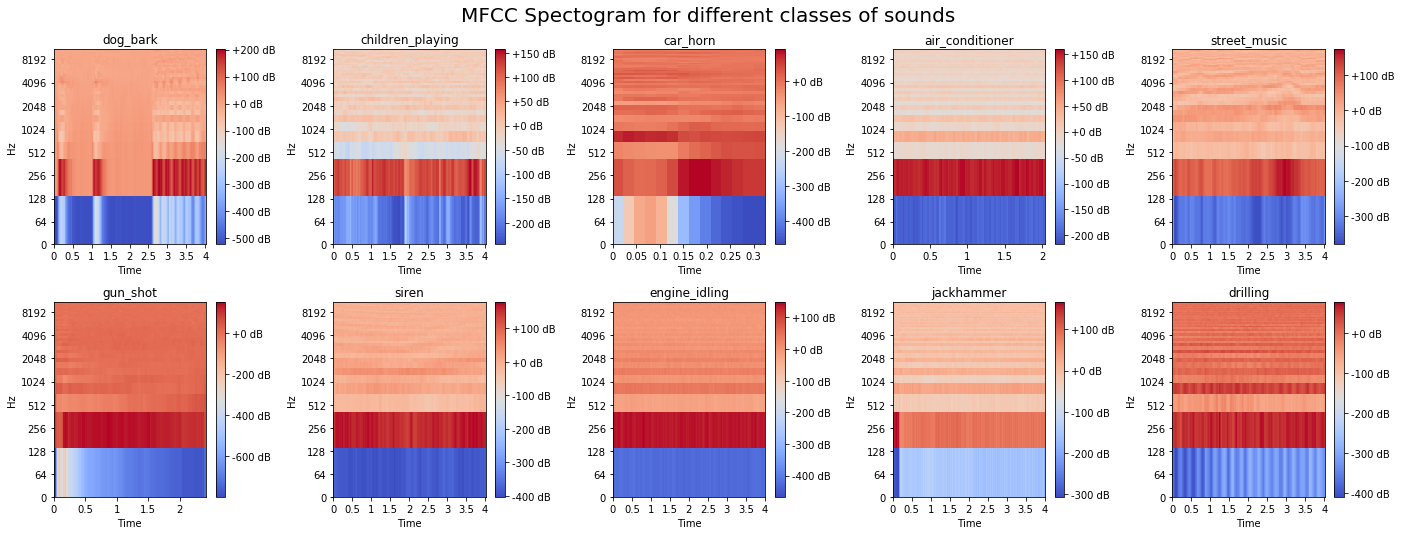

In [99]:
fig = plt.figure(figsize=(20, 8))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
classes = list(meta_data['class'].unique()) 
plt.title('MFCC Spectogram for different classes of sounds\n',size=20)
plt.axis('off')
for i in range(10):
    fig.add_subplot(2,5,i+1)
    plt.title(classes[i])
    plt.ylabel('Amplitude')
    file_name = 'sample_sound/'+classes[i]+".wav"
    mfcc_ = feature_extractor(file_name)
    #mfcc_ = feature_extractor(file_name,padding=True,max_pad=174)
    librosa.display.specshow(mfcc_,x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

In [ ]:
# # Draw the MFCC Spectrogram for each class
# fig = plt.figure(figsize=(20, 8))
# fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
# plt.title('MFCC for different class of sounds\n',size=20)
# plt.axis('off')
# for i in range(10):
#     fig.add_subplot(2,5,i+1)
#     plt.title(str(sound_class_dic.index[i][0]))
#     librosa.display.specshow(sound_sample[i]['feature'], x_axis='time', y_axis='log')
#     plt.colorbar(format='%+2.0f dB')
#     plt.tight_layout()

### Label Encoding

In [46]:
# Convert features and corresponding classification labels into numpy arrays
X_1D = np.array(features_1D.feature.tolist())
y_1D = np.array(features_1D.class_label.tolist())

# Encode the classification labels
label_encoder = LabelEncoder()
yy_1D = to_categorical(label_encoder.fit_transform(y_1D))

In [47]:
# Convert features and corresponding classification labels into numpy arrays
X_2D = np.array(features_2D.feature.tolist())
y_2D = np.array(features_2D.class_label.tolist())

# Encode the classification labels
yy_2D = to_categorical(label_encoder.transform(y_2D)) 

### Splitting the Dataset

In [48]:
x_train_sl_1D, x_test_sl_1D, y_train_sl_1D, y_test_sl_1D = train_test_split(X_1D,y_1D,test_size=0.2,random_state =27)
# x_train_sl_2D, x_test_sl_2D, y_train_sl_2D, y_test_sl_2D = train_test_split(
#     X_2D.reshape(X_2D.shape[0],X_2D.shape[1]*X_2D.shape[2]),yy_2D,test_size=0.2,random_state = 42)
x_train_1D, x_test_1D, y_train_1D, y_test_1D = train_test_split(X_1D, yy_1D, test_size=0.2, random_state = 27)
x_train_2D, x_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, yy_2D, test_size=0.2, random_state = 27)

****
****

# Classification using Different Algorithms

Following will be used for classification:    
    
1. Random Forest
2. Support Vector Machine 
2. Mulit-layer Perceptron (ANN)
3. Convolutional Neural Network (CNN)

## 1. Random Forest Classification

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [15]:
clf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=100)
clf.fit(x_train_sl_1D,y_train_sl_1D)
y_pred = clf.predict(x_test_sl_1D)
train_accu =  clf.score(x_train_sl_1D, y_train_sl_1D)
test_accu = clf.score(x_test_sl_1D, y_test_sl_1D)
print('Training Accuracy:', train_accu)
print('Test Accuracy:', test_accu)

Training Accuracy: 0.5574803149606299
Test Accuracy: 0.522610188895249


**!! Not so Good !!**

## 2. Support Vector Machine   

In [49]:
import pickle
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Grid Search for hyper parameter selection

In [21]:
#search the hyperparameter space to find the best model
tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma': [1e-3, 1e-4, 1e-5],
                     'C': [1, 10 ,20,30,40,50]}]
#                    , {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
searchpara = GridSearchCV(svm.SVC(), tuned_parameters)
searchpara.fit(x_train_sl_1D, y_train_sl_1D)
searchpara.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

### Model Execution

In [ ]:
# construct the model by the best hyperparameters found above
SVM = svm.SVC(C=10.0, gamma=0.001)

# train the model
SVM.fit(x_train_sl_1D,y_train_sl_1D)

y_pred = SVM.predict(x_test_sl_1D)


In [26]:
train_accu =  SVM.score(x_train_sl_1D, y_train_sl_1D)
test_accu = SVM.score(x_test_sl_1D, y_test_sl_1D)

print('Training Accuracy: %.4f%%'% (train_accu*100))
print('Test Accuracy: %.4f%%'% (test_accu*100))

Training Accuracy: 99.8282%
Test Accuracy: 89.8683%


### Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

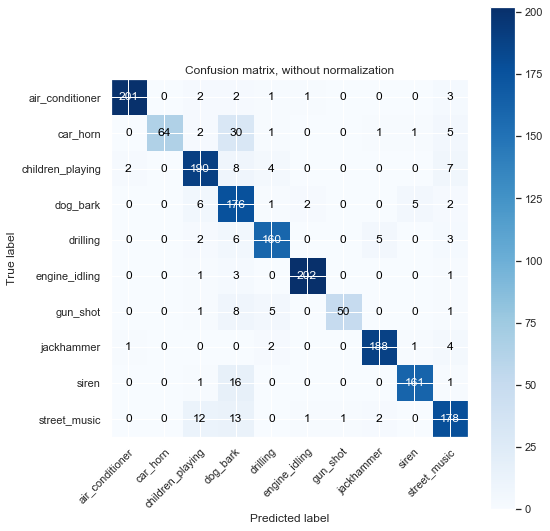

In [120]:
class_names = meta_data.groupby(['class', 'classID'], as_index = False).sum()['class']
plot_confusion_matrix(y_test_sl_1D, y_pred, classes=class_names, cmap=plt.cm.Blues)
plt.show()

## 3. Multi-Layer perceptron

In [50]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 

### Model Definition

In [52]:
n_labels = yy_1D.shape[1]
in_shape = x_train_1D.shape[1]
n_layers = 2
n_nodes = 100

model_num = 4

# Construct model 
model = Sequential()

model.add(Dense(n_nodes, input_shape=(in_shape,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_nodes))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Model Summary

In [53]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_train_1D, y_train_1D, verbose=0)
accuracy = 100*score[1] 

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

### Model Execution

In [54]:
n_epochs = 100
n_batch = 32

start = datetime.now()

history = model.fit(x_train_1D, 
                    y_train_1D,
                    batch_size=n_batch,
                    epochs=n_epochs,
                    validation_data=(x_test_1D, y_test_1D),
                    verbose=1)

duration = datetime.now() - start
print("Training finished in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 1s 134us/step - loss: 13.4955 - accuracy: 0.1480 - val_loss: 2.1828 - val_accuracy: 0.1568
Epoch 2/100
6985/6985 [==============================] - 1s 109us/step - loss: 2.7940 - accuracy: 0.1596 - val_loss: 2.2163 - val_accuracy: 0.1780
Epoch 3/100
6985/6985 [==============================] - 1s 114us/step - loss: 2.3436 - accuracy: 0.1938 - val_loss: 2.1796 - val_accuracy: 0.2078
Epoch 4/100
6985/6985 [==============================] - 1s 110us/step - loss: 2.2008 - accuracy: 0.2188 - val_loss: 2.0917 - val_accuracy: 0.2467
Epoch 5/100
6985/6985 [==============================] - 1s 111us/step - loss: 2.1252 - accuracy: 0.2471 - val_loss: 1.9948 - val_accuracy: 0.2891
Epoch 6/100
6985/6985 [==============================] - 1s 110us/step - loss: 2.0091 - accuracy: 0.2789 - val_loss: 1.8860 - val_accuracy: 0.3537
Epoch 7/100
6985/6985 [==============================] - 1s 109us/ste

### Model Evalutaion

In [55]:
# Evaluating the model on the training and testing set
acc_train = model.evaluate(x_train_1D, y_train_1D, verbose=0)
print("Training Accuracy: ", acc_train[1])

acc_test = model.evaluate(x_test_1D, y_test_1D, verbose=0)
print("Testing Accuracy: ", acc_test[1])

Training Accuracy:  0.8292054533958435
Testing Accuracy:  0.7716084718704224


In [56]:
#ann_dict = dict()
model_name = "Model_"+str(model_num)
ann_dict[model_name] = {"Batch_size":n_batch,
                        "Epochs":n_epochs,
                        "Hidden_layers": n_layers, 
                        "Nodes":n_nodes, 
                        "train_acc":acc_train,
                        "test_acc":acc_test,
                        "Model_History":history }
ann_dict.keys()

dict_keys(['Model_1', 'Model_3', 'Model_2', 'Model_4'])

In [57]:
f = open("ann_dict.pkl","wb")
pickle.dump(ann_dict,f)
f.close()

In [80]:
ann_dict

{'Model_1': {'Batch_size': 32,
  'Epochs': 250,
  'Hidden_layers': 2,
  'Model_History': <keras.callbacks.callbacks.History at 0x7fa258248f98>,
  'Nodes': 300,
  'test_acc': [0.36848596183654575, 0.8906697034835815],
  'train_acc': [0.12741352181972332, 0.9689334034919739]},
 'Model_2': {'Batch_size': 64,
  'Epochs': 200,
  'Hidden_layers': 2,
  'Model_History': <keras.callbacks.callbacks.History at 0x7fa19c521668>,
  'Nodes': 250,
  'test_acc': [0.38216666182109676, 0.8849456310272217],
  'train_acc': [0.16069991685658075, 0.9584824442863464]},
 'Model_3': {'Batch_size': 16,
  'Epochs': 200,
  'Hidden_layers': 2,
  'Model_History': <keras.callbacks.callbacks.History at 0x7fa19c475400>,
  'Nodes': 200,
  'test_acc': [0.5023112805761742, 0.8368632197380066],
  'train_acc': [0.30687325080095357, 0.913672149181366]},
 'Model_4': {'Batch_size': 32,
  'Epochs': 100,
  'Hidden_layers': 2,
  'Model_History': <keras.callbacks.callbacks.History at 0x7fa19c3acb00>,
  'Nodes': 100,
  'test_acc': 

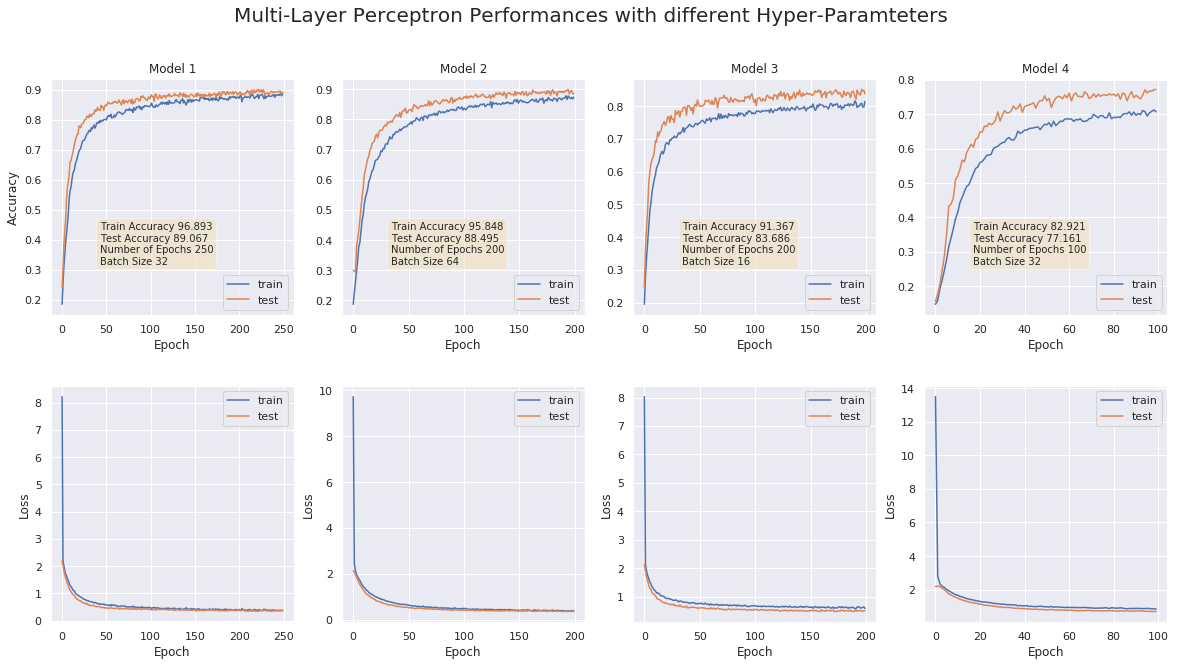

In [94]:
fig, axs = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

for i in range(4):
    model_name = "Model_"+str(i+1)
    history = ann_dict[model_name]["Model_History"]
    axs[0,i].plot(history.history['accuracy'])
    axs[0,i].plot(history.history['val_accuracy'])
    axs[0,0].set_ylabel("Accuracy")
    axs[0,i].set_xlabel("Epoch")
    axs[0,i].set_title("Model %s"%(i+1))
    axs[0,i].legend(['train', 'test'], loc='lower right')
    axs[1,i].plot(history.history['loss'])
    axs[1,i].plot(history.history['val_loss'])
    axs[1,i].set_ylabel("Loss")
    axs[1,i].set_xlabel("Epoch")
    axs[1,i].legend(['train', 'test'], loc='upper right')
    
    train_acc = round(ann_dict[model_name]["train_acc"][1]*100,3)
    test_acc = round(ann_dict[model_name]["test_acc"][1]*100,3)
    epochs = ann_dict[model_name]["Epochs"]
    batch_s = ann_dict[model_name]["Batch_size"]
    text = '\n'.join(("Train Accuracy %s"%train_acc,
                      "Test Accuracy %s"%test_acc,
                      "Number of Epochs %s"%epochs,
                      "Batch Size %s"%batch_s))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    axs[0,i].text(0.2, 0.3, text, transform=axs[0,i].transAxes, fontsize=10,
            verticalalignment='center', bbox=props)
    
fig.suptitle("Multi-Layer Perceptron Performances with different Hyper-Paramteters",size=20)    
plt.show()

****
****

## 4. Convolutional Neural Network

In [143]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from keras.models import model_from_json

### Data reshaping 

In [52]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train_2D = x_train_2D.reshape(x_train_2D.shape[0], num_rows, num_columns, num_channels)
x_test_2D = x_test_2D.reshape(x_test_2D.shape[0], num_rows, num_columns, num_channels)

num_labels = yy_2D.shape[1]
filter_size = 2

### Model Definition

In [131]:
# Model Configuration

cnn_model_num = 5

n_labels = yy_1D.shape[1]
n_conv_layers = 4
n_mlp_layers = 2

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
#model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Summarizing Model

In [132]:
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test_2D, y_test_2D, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 41, 64)        

### Model Execution

In [133]:
num_epochs = 200
num_batch_size = 256

start = datetime.now()

history = model.fit(x_train_2D, 
          y_train_2D, 
          batch_size=num_batch_size, 
          epochs=num_epochs, 
          validation_data=(x_test_2D, y_test_2D),  
          verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/200
6985/6985 [==============================] - 1s 161us/step - loss: 4.8880 - accuracy: 0.1246 - val_loss: 2.2856 - val_accuracy: 0.1528
Epoch 2/200
6985/6985 [==============================] - 1s 97us/step - loss: 2.2595 - accuracy: 0.1452 - val_loss: 2.2440 - val_accuracy: 0.1774
Epoch 3/200
6985/6985 [==============================] - 1s 97us/step - loss: 2.1721 - accuracy: 0.1977 - val_loss: 2.0792 - val_accuracy: 0.2925
Epoch 4/200
6985/6985 [==============================] - 1s 96us/step - loss: 2.0247 - accuracy: 0.2538 - val_loss: 1.9463 - val_accuracy: 0.3240
Epoch 5/200
6985/6985 [==============================] - 1s 96us/step - loss: 1.9188 - accuracy: 0.2888 - val_loss: 1.8571 - val_accuracy: 0.3904
Epoch 6/200
6985/6985 [==============================] - 1s 95us/step - loss: 1.8255 - accuracy: 0.3309 - val_loss: 1.7351 - val_accuracy: 0.4356
Epoch 7/200
6985/6985 [==============================] - 1s 96us/step - los

In [134]:
# Evaluating the model on the training and testing set
cnn_acc_train = model.evaluate(x_train_2D, y_train_2D, verbose=0)
print("Training Accuracy: ", cnn_acc_train[1])

cnn_acc_test = model.evaluate(x_test_2D, y_test_2D, verbose=0)
print("Testing Accuracy: ", cnn_acc_test[1])

Training Accuracy:  0.9975662231445312
Testing Accuracy:  0.9238694906234741


In [135]:
#cnn_dict = dict()
model_name = "Model_"+str(cnn_model_num)
cnn_dict[model_name] = {"Batch_size":num_batch_size,
                        "n_cov_layers": n_conv_layers,
                        "n_mlp_layers": n_mlp_layers,
                        "Epochs":num_epochs,
                        "train_acc":cnn_acc_train,
                        "test_acc":cnn_acc_test,
                        "Model_History":history }
cnn_dict.keys()

dict_keys(['Model_1', 'Model_3', 'Model_4', 'Model_5', 'Model_2'])

In [136]:
f = open("cnn_dict.pkl","wb")
pickle.dump(cnn_dict,f)
f.close()

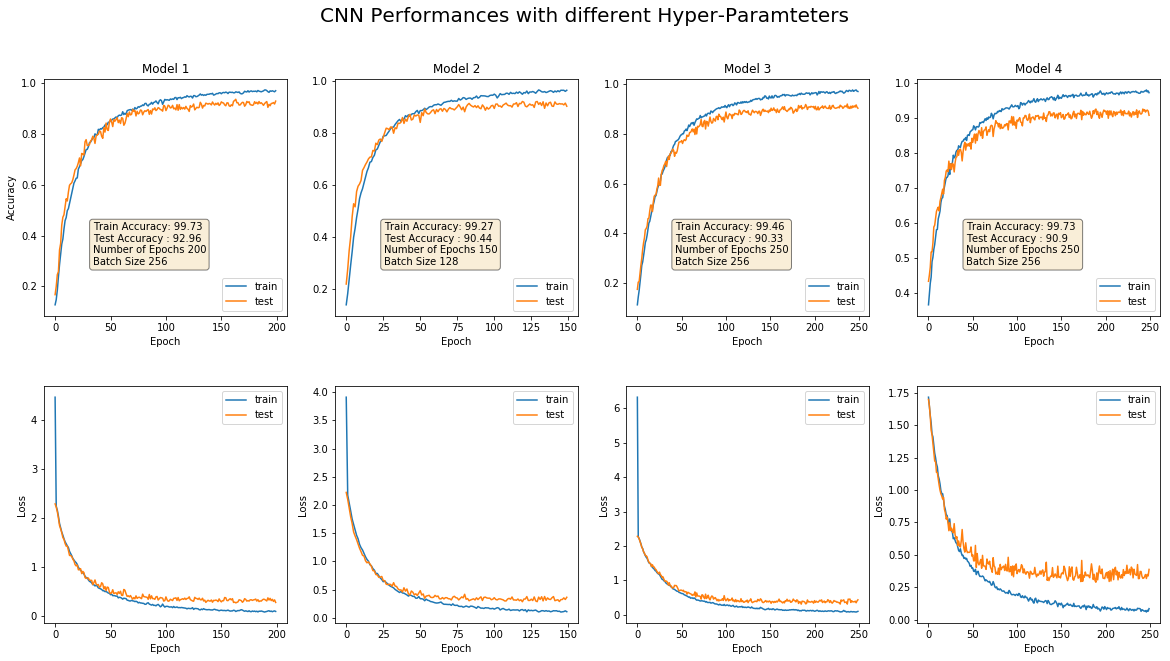

In [137]:
fig, axs = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'hspace': 0.3, 'wspace': 0.2})

for i in range(4):
    model_name = "Model_"+str(i+1)
    history = cnn_dict[model_name]["Model_History"]
    axs[0,i].plot(history.history['accuracy'])
    axs[0,i].plot(history.history['val_accuracy'])
    axs[0,0].set_ylabel("Accuracy")
    axs[0,i].set_xlabel("Epoch")
    axs[0,i].set_title("Model %s"%(i+1))
    axs[0,i].legend(['train', 'test'], loc='lower right')
    axs[1,i].plot(history.history['loss'])
    axs[1,i].plot(history.history['val_loss'])
    axs[1,i].set_ylabel("Loss")
    axs[1,i].set_xlabel("Epoch")
    axs[1,i].legend(['train', 'test'], loc='upper right')
    
    train_acc = round(cnn_dict[model_name]["train_acc"][1]*100,2)
    test_acc = round(cnn_dict[model_name]["test_acc"][1]*100,2)
    epochs = cnn_dict[model_name]["Epochs"]
    batch_s = cnn_dict[model_name]["Batch_size"]
    text = '\n'.join(("Train Accuracy: %s"%train_acc,
                      "Test Accuracy : %s"%test_acc,
                      "Number of Epochs %s"%epochs,
                      "Batch Size %s"%batch_s))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    axs[0,i].text(0.2, 0.3, text, transform=axs[0,i].transAxes, fontsize=10,
            verticalalignment='center', bbox=props)
    
fig.suptitle("CNN Performances with different Hyper-Paramteters",size=20)    
plt.show()

In [140]:
cnn_dict

{'Model_1': {'Batch_size': 256,
  'Epochs': 200,
  'Model_History': <keras.callbacks.callbacks.History at 0x7f26441b6f28>,
  'n_cov_layers': 3,
  'n_mlp_layers': 2,
  'test_acc': [0.278491083050651, 0.929593563079834],
  'train_acc': [0.014632594682557683, 0.9972798824310303]},
 'Model_2': {'Batch_size': 128,
  'Epochs': 150,
  'Model_History': <keras.callbacks.callbacks.History at 0x7f26104afa90>,
  'n_cov_layers': 3,
  'n_mlp_layers': 2,
  'test_acc': [0.3632657332084625, 0.9044075608253479],
  'train_acc': [0.0253111185774681, 0.9926986694335938]},
 'Model_3': {'Batch_size': 256,
  'Epochs': 250,
  'Model_History': <keras.callbacks.callbacks.History at 0x7f2600431320>,
  'n_cov_layers': 4,
  'n_mlp_layers': 2,
  'test_acc': [0.4325710720460996, 0.903262734413147],
  'train_acc': [0.016577159828551742, 0.9945597648620605]},
 'Model_4': {'Batch_size': 256,
  'Epochs': 250,
  'Model_History': <keras.callbacks.callbacks.History at 0x7f263e8f45f8>,
  'n_cov_layers': 4,
  'n_mlp_layers': 

In [139]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [144]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [145]:
loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
score = loaded_model.evaluate(x_test_2D, y_test_2D, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 92.39%


In [111]:
def predict(file_name):
    pred_feature = extract_features(file_name) 
    pred_feature = pred_feature.reshape(1, num_rows, num_columns, num_channels)

    pred_v = model.predict_classes(pred_feature)
    pred_clacces = label_encoder_2D.inverse_transform(pred_v) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f'))